In [1]:
import torch

In [40]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data_points = []
class_labels = []

with open('Data/mnist_train_file.txt') as fs:
    for line in fs:
        data = list(map(int, line.strip().split(','))) 
        label = data[0]
        datapoint = data[1:]
        data_points.append(datapoint)
        class_labels.append(label)

In [4]:
print(len(data_points))

60000


In [5]:
len(data_points[0]) ## 28 x 28 = 784

784

In [6]:
class Mnist_dataset(Dataset):
    def __init__(self, data_points, class_labels):
        super(Dataset, self).__init__()
        self.data = data_points
        self.labels = class_labels
    
    def __len__(self):
        # returns length of the dataset
        return len(self.labels)
    
    def __getitem__(self, index):
        # retrieves an item of a given index
        d = torch.FloatTensor(self.data[index])
        l = torch.LongTensor([self.labels[index]])
        return d,l

In [41]:
mnist_data = Mnist_dataset(data_points, class_labels)

In [42]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [62]:
G = generator()

In [44]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [63]:
D = discriminator()

In [64]:
epochs = 100
lr = 0.0002
batch_size = 64
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [65]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(1, 128)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0

In [66]:
train_dataloader = DataLoader(mnist_data, batch_size=batch_size)

In [67]:
# Training Loop
# Code adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        d_optimizer.zero_grad()
        # Format batch
        real_data = data[0]
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        #print(real_data.shape)
        output = D(real_data).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        #print(errD_real)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        #print(fake.shape)
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        g_optimizer.step()
        
        # Output training stats
        #if i % 50 == 0:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, epochs, i, len(train_dataloader),
        #             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())     
        

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Starting Training Loop...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:40:01<00:00, 60.01s/it]


In [86]:
fixed_noise = torch.randn(1, 128)

In [87]:
fixed_noise

tensor([[-0.4892,  1.8759,  0.0971,  2.1452,  0.8780,  0.0964, -0.1903, -0.6248,
          1.6668, -0.1235,  0.5641, -1.9917,  0.0731,  0.5406,  2.1486,  0.0496,
          0.0515, -2.1160, -0.9580, -1.0199,  0.9723, -0.4940, -0.5654, -0.8745,
         -1.7433,  0.1272,  0.0637,  1.8516,  0.4121,  2.6799,  0.9687, -0.3016,
         -0.0905, -0.9719, -1.9745, -0.5294, -0.9834,  0.7691,  0.5797,  0.3526,
          0.3010,  1.5277, -0.8418, -0.1558, -0.3043,  0.0795,  1.1885,  0.6338,
         -1.1319, -0.4131, -1.9412,  1.7427,  0.8135, -0.2667,  1.9417, -0.4845,
         -0.4865, -0.9703,  1.5727, -0.2267,  0.1825, -0.5286, -1.3106,  2.3532,
         -0.1123,  0.6683, -0.9633, -1.6179, -0.4430,  0.5996, -0.6076,  0.2288,
          1.2165, -1.2243, -1.3884, -2.3588,  1.0417, -0.5529, -0.6589, -0.5621,
          1.0849,  1.3668, -0.0980,  0.2787, -0.1549, -0.0313,  0.9107,  0.5046,
          0.7897, -2.1784,  1.4261, -0.2946, -0.4257, -0.2377,  0.0956, -0.5347,
          0.1352,  0.5850, -

In [88]:
fake = G(fixed_noise).detach()

In [89]:
img = fake.reshape(28, 28)

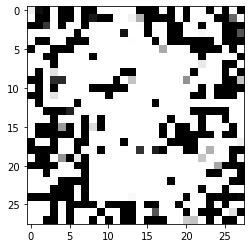

In [90]:
plt.imshow(img.numpy(),cmap='gray')